[보험 예측 - 다섯가지 회귀로]

1. 필요한 라이브러리 받고 데이터셋 받기

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder

from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [5]:
df=pd.read_csv('/Users/bluecloud/Documents/대학/유런/데이터셋/insurance.csv')

In [7]:
df.head(10)

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
5,31,female,25.740,0,no,southeast,3756.62160
6,46,female,33.440,1,no,southeast,8240.58960
7,37,female,27.740,3,no,northwest,7281.50560
8,37,male,29.830,2,no,northeast,6406.41070
9,60,female,25.840,0,no,northwest,28923.13692


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [11]:
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [13]:
df.shape

(1338, 7)

In [15]:
df.isnull().sum().sort_values(ascending=False)

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

데이터셋 정보
- 일곱개의 칼럼, 1338개 세트, null은 없음(굿굳)
- 성별, 흡연유무, 지역은 object형 >> 성별과 흡연유무는 0과1로 float형으로 바꿔도 ㄱㅊ을듯ㄴ, 지역은 3가지이니까 0,1,2...로 바꿔도 그게 회귀에서 의미가 있을까..?

2. 각 칼럼별 밀도(수치인듯) 구해보기

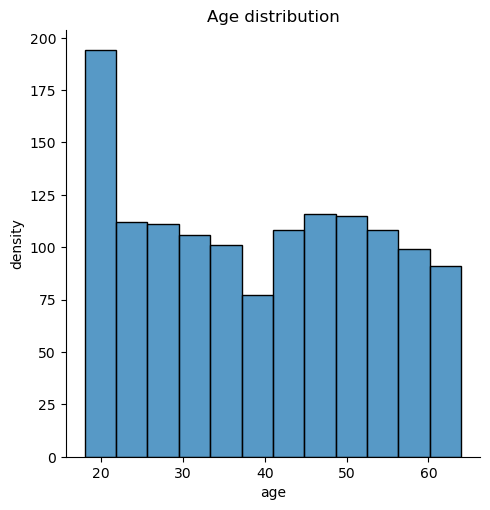

In [17]:
# 나이
sns.displot(df['age'])
plt.title('Age distribution')
plt.ylabel('density')
plt.xlabel('age')
plt.show()

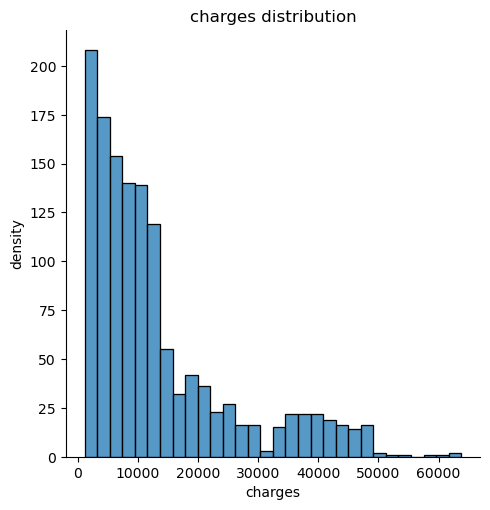

In [19]:
# charges
sns.displot(df['charges'])
plt.title('charges distribution')
plt.ylabel('density')
plt.xlabel('charges')
plt.show()

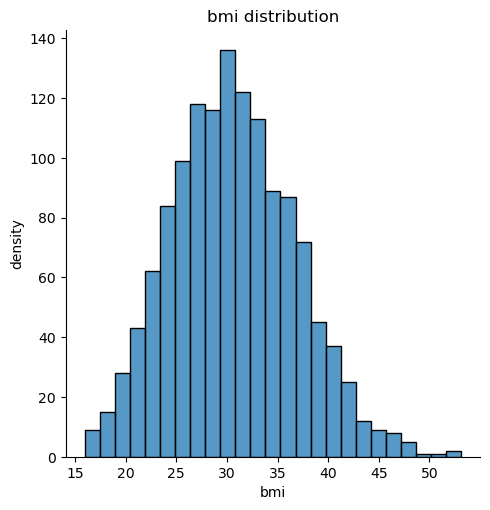

In [21]:
#bmi
sns.displot(df['bmi'])
plt.title('bmi distribution')
plt.ylabel('density')
plt.xlabel('bmi')
plt.show()

3. 각 열의 고유값 반환 >> 각 항목별 분포 살펴보기용..?

- 근데 kaggle 코드대로하면 x,y축 바뀌어서 나옴 >> sns.countplot(x='칼럼명', data=데이터명)으로 정해줘야할듯

In [23]:
# 지역
df['region'].value_counts()

region
southeast    364
southwest    325
northwest    325
northeast    324
Name: count, dtype: int64

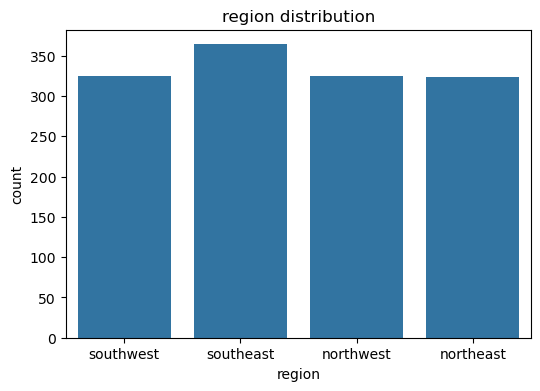

In [25]:
# 지역별 카운트 표로 나타내기
fig = plt.figure(figsize = (6,4))
sns.countplot(x='region',data=df)
plt.title('region distribution')
plt.show()

In [29]:
# 성별
df['sex'].value_counts()

sex
male      676
female    662
Name: count, dtype: int64

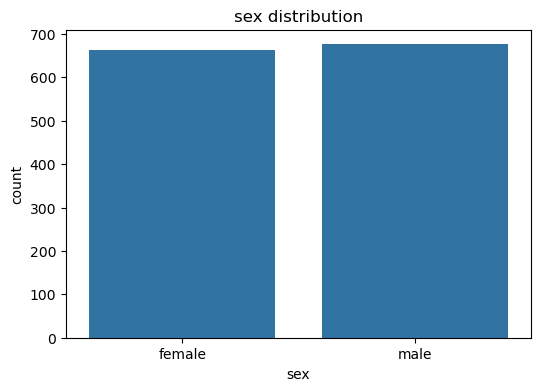

In [33]:
fig = plt.figure(figsize = (6,4))
sns.countplot(x='sex',data=df)
plt.title('sex distribution')
plt.show()

In [47]:
# 아이수
df['children'].value_counts()

children
0    574
1    324
2    240
3    157
4     25
5     18
Name: count, dtype: int64

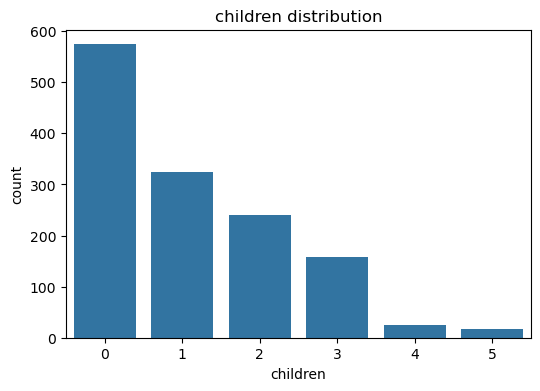

In [37]:
fig = plt.figure(figsize = (6,4))
sns.countplot(x='children', data=df)
plt.title('children distribution')
plt.show()

4. 상관관계 분석

- factorize() : 범주형 데이터에 숫자 붙여서 인코딩 > 인코딩 결과를 튜플로 반환
- corr() : 누락값제외하고 전체 데이터간의 상관관계 계산

In [51]:
# 범주형 데이터 >> 숫자로 인코딩 : 성별, 지역, 흡연유무 칼럼만
df['sex'] = pd.factorize(df['sex'])[0] + 1
df['region'] = pd.factorize(df['region'])[0] + 1
df['smoker'] = pd.factorize(df['smoker'])[0] + 1
# 상관관계 계산 >> charges 칼럼과의 상관관계 출력
corr = df.corr()
corr['charges'].sort_values(ascending=False)

charges     1.000000
age         0.299008
bmi         0.198341
children    0.067998
sex         0.057292
region      0.006208
smoker     -0.787251
Name: charges, dtype: float64

- pearson 상관계수 :  두 변수 간의 선형적 상관관계를 측정하며 [−1,1]사이의 값을 출력

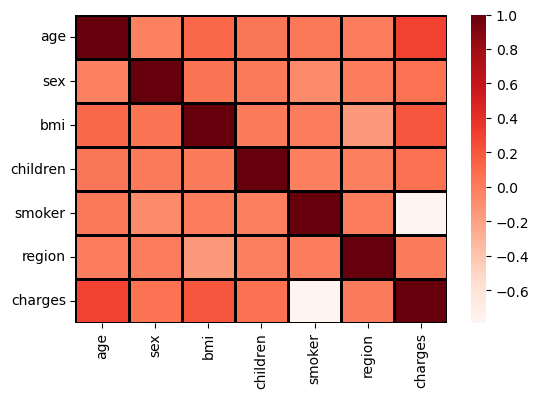

In [53]:
# 함수를 그려봅시다
fig=plt.figure(figsize=(6,4))
data_ploting=df.corr(method='pearson')
sns.heatmap(data_ploting,cmap='Reds',linecolor='black',linewidths=2)
plt.show()

5. 산점도

<Figure size 600x400 with 0 Axes>

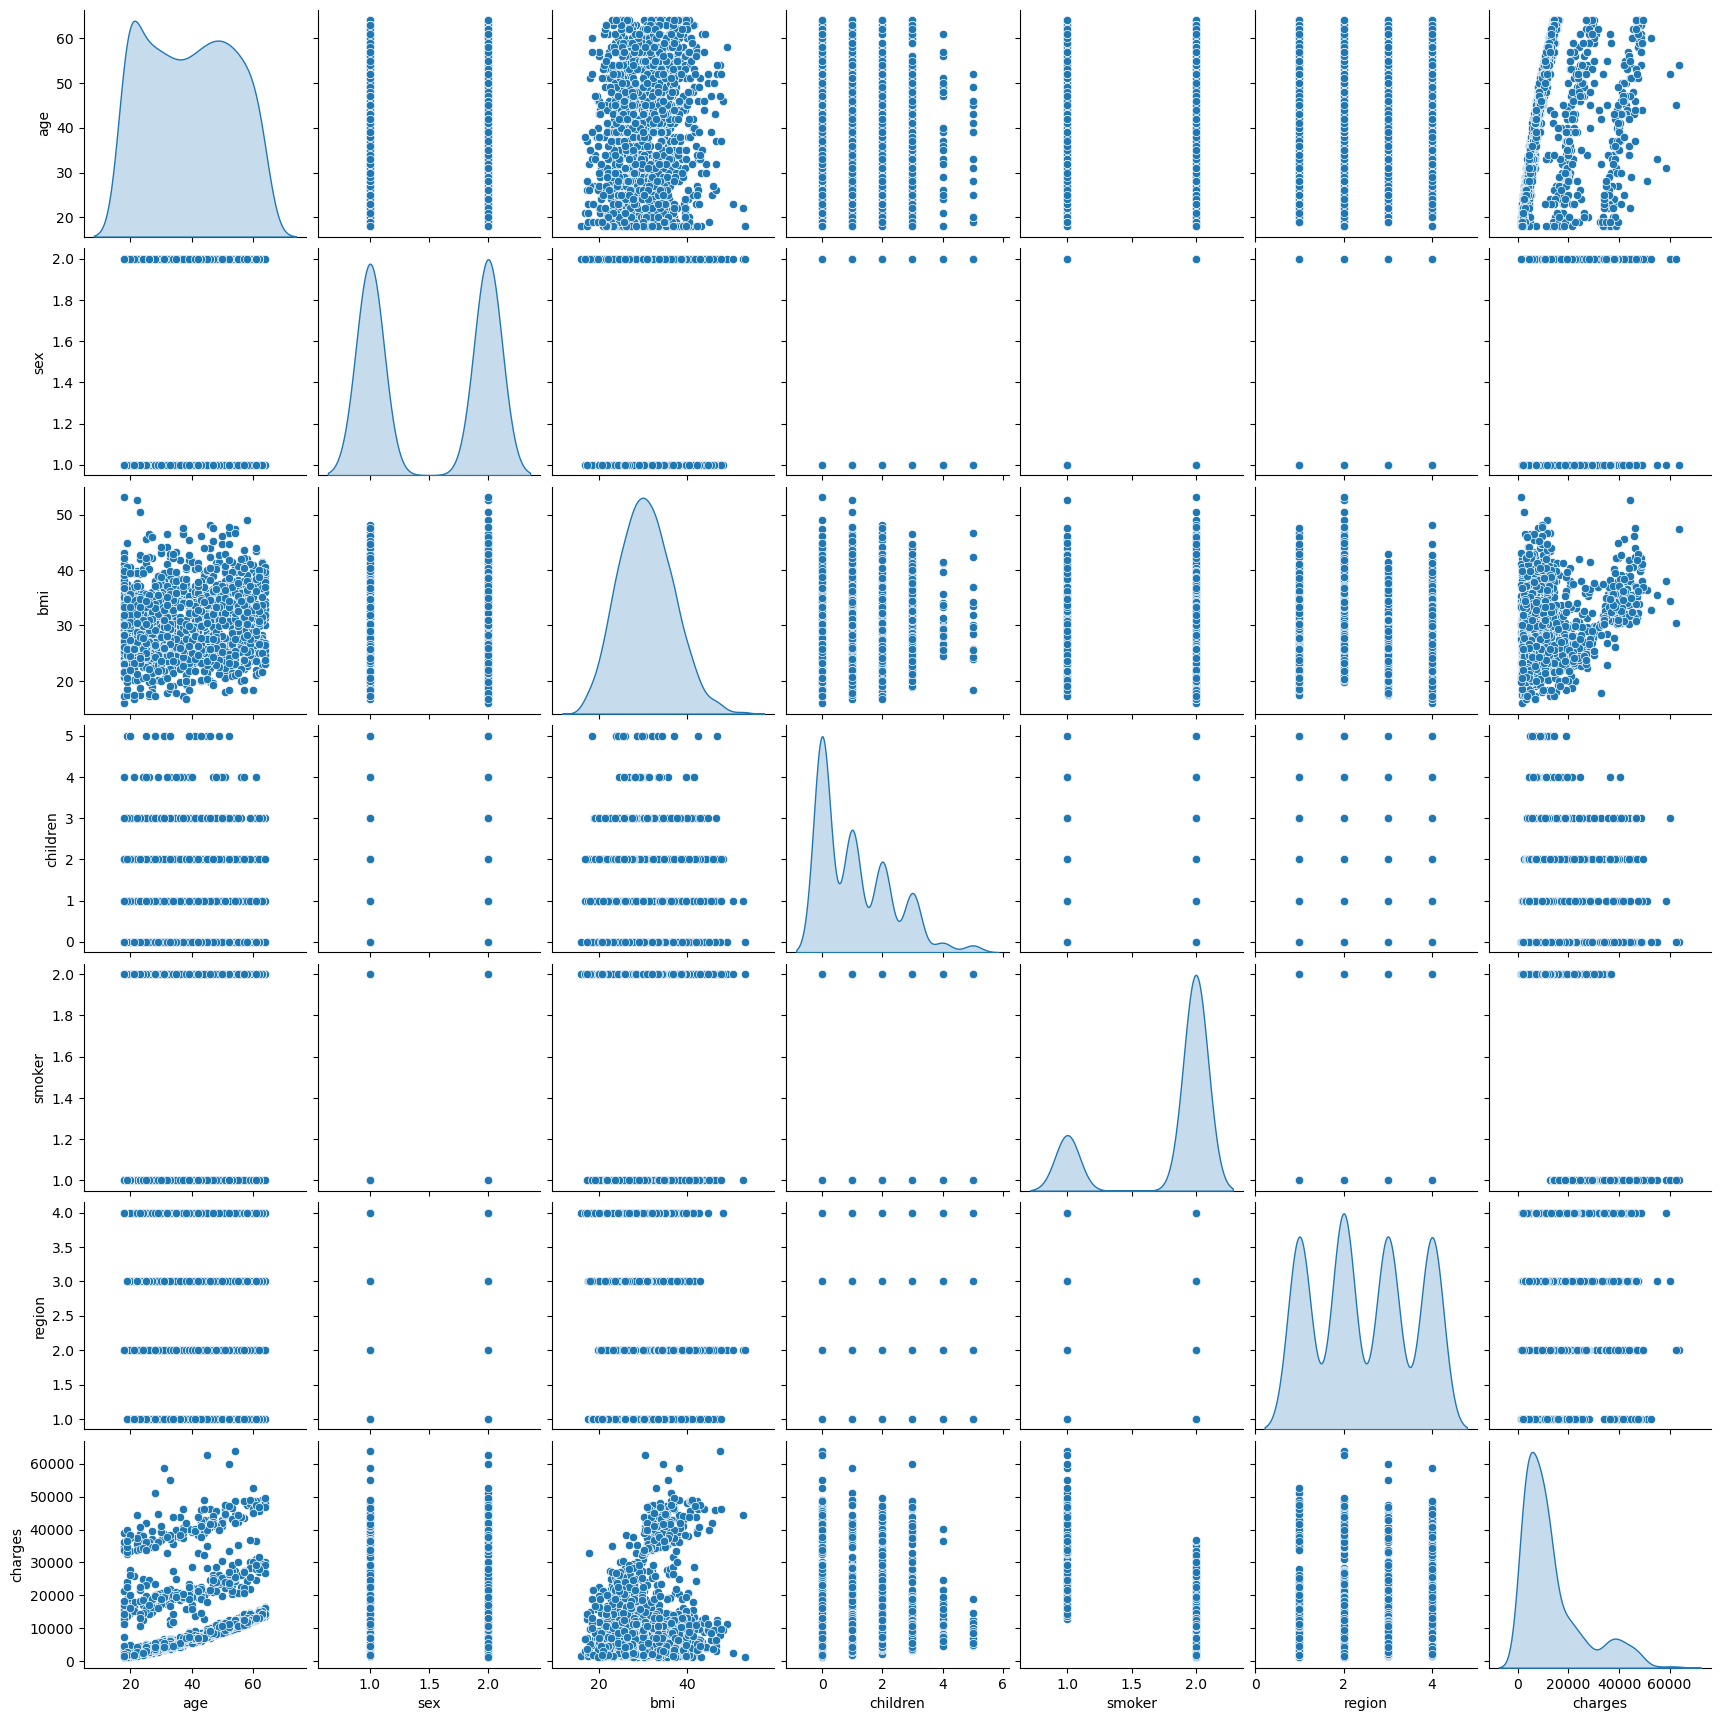

In [55]:
fig = plt.figure(figsize = (6, 4))
sns.pairplot(df,diag_kind='kde');

6. 데이터 나누고 스케일링

In [69]:
# charges를 픽해서 y로
X=df.drop('charges',axis=1)
y=df['charges']
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.3, random_state=101)

- 스케일링 : 표준화 분산 1, 평균 0으로
- transform() : 테스트와 트레인셋에 스케일링 적용 

In [71]:
scaler=StandardScaler()
scaler.fit(X_train)
X_train_scaled=scaler.transform(X_train)
X_test_scaled=scaler.transform(X_test)

7. 선형회귀모델

In [75]:
#fit():모델을 학습, 입력 데이터와 정답 데이터를 모델에 입력하여 모델의 가중치(weight)를 업데이트
lr=LinearRegression()
lr.fit(X_train_scaled,y_train)

LinearRegression()

- 모델 예측하고 성능평가

In [89]:
# predict() >> 모델을 예측한 타깃값의 배열 만들기
y_pred=lr.predict(X_test_scaled)
y_pred=pd.DataFrame(y_pred)
# 성능평가
mae_lr=metrics.mean_absolute_error(y_test,y_pred)
mse_lr=metrics.mean_squared_error(y_test,y_pred)
rmse_lr=np.sqrt(mse_val)
pd.DataFrame([mae_lr,mse_lr,rmse_lr],index=['mae_lr','mse_lr','rmse_lr'],columns=['Metrics'])

,Metrics
mae_lr,3.990250e+03
mse_lr,3.353013e+07
rmse_lr,5.790521e+03


In [91]:
# 선형회귀모델을 교차검증으로 평가
scores=cross_val_score(lr,X_train_scaled,y_train,cv=5)
print(np.sqrt(scores))

[0.88791389 0.85653048 0.84404195 0.87198372 0.84417492]


In [93]:
# 결정계수를 출력 : 상관계수를 제곱한 값 >> 회귀 모델의 성능에 대한 평가 지표
r2_score(y_test,lr.predict(X_test_scaled))

0.7613126015198817

8. 그레디언트부스팅
- 여러개의 결정 트리를 묶어 모델을 만드는 앙상블 기법

In [95]:
gbm_reg=GradientBoostingRegressor()
gbm_reg.fit(X_train_scaled,y_train)

GradientBoostingRegressor()

In [97]:
# predict() >> 모델을 예측한 타깃값의 배열 만들기
y_pred=gbm_reg.predict(X_test_scaled)
y_pred=pd.DataFrame(y_pred)
# 성능평가
mae_gbm_reg=metrics.mean_absolute_error(y_test,y_pred)
mse_gbm_reg=metrics.mean_squared_error(y_test,y_pred)
rmse_gbm_reg=np.sqrt(mse_gbm_reg)
pd.DataFrame([mae_gbm_reg,mse_gbm_reg,rmse_gbm_reg],index=['mae_gbm_reg','mse_gbm_reg','rmse_gbm_reg'],columns=['Metrics'])

,Metrics
mae_gbm_reg,2.526184e+03
mse_gbm_reg,2.110072e+07
rmse_gbm_reg,4.593552e+03


In [99]:
# 선형회귀모델을 교차검증으로 평가
scores=cross_val_score(gbm_reg,X_train_scaled,y_train,cv=5)
print(np.sqrt(scores))
# 결정계수를 출력 : 상관계수를 제곱한 값 >> 회귀 모델의 성능에 대한 평가 지표
r2_score(y_test,gbm_reg.predict(X_test_scaled))

[0.94595821 0.91429319 0.91687262 0.92414564 0.91716787]


0.849792542412332

9. XGB Regressor Model 
- 약한 분류기를 세트로 묶어서 정확도를 예측하는 기법
- 예측이 좋음

In [101]:
xgb_reg=XGBRegressor()
xgb_reg.fit(X_train_scaled,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [105]:
# predict() >> 모델을 예측한 타깃값의 배열 만들기
y_pred=xgb_reg.predict(X_test_scaled)
y_pred=pd.DataFrame(y_pred)
# 성능평가
mae_xgb_reg=metrics.mean_absolute_error(y_test,y_pred)
mse_xgb_reg=metrics.mean_squared_error(y_test,y_pred)
rmse_xgb_reg=np.sqrt(mse_xgb_reg)
pd.DataFrame([mae_xgb_reg,mse_xgb_reg,rmse_xgb_reg],index=['mae_xgb_reg','mse_xgb_reg','rmse_xgb_reg'],columns=['Metrics'])

,Metrics
mae_xgb_reg,3.142590e+03
mse_xgb_reg,2.976529e+07
rmse_xgb_reg,5.455757e+03


In [107]:
# 선형회귀모델을 교차검증으로 평가
scores=cross_val_score(xgb_reg,X_train_scaled,y_train,cv=5)
print(np.sqrt(scores))
# 결정계수를 출력 : 상관계수를 제곱한 값 >> 회귀 모델의 성능에 대한 평가 지표
r2_score(y_test,xgb_reg.predict(X_test_scaled))

[0.91782241 0.88730325 0.90410079 0.90440364 0.88383429]


0.7881129907007072

10. Decision Tree Regressor Model
- 입력값과 해당 출력값의 연속적인 데이터를 이용해 예측 모델을 생성하는데 사용

In [109]:
dt_reg=DecisionTreeRegressor()
dt_reg.fit(X_train_scaled,y_train)

DecisionTreeRegressor()

In [111]:
# predict() >> 모델을 예측한 타깃값의 배열 만들기
y_pred=dt_reg.predict(X_test_scaled)
y_pred=pd.DataFrame(y_pred)
# 성능평가
mae_dt_reg=metrics.mean_absolute_error(y_test,y_pred)
mse_dt_reg=metrics.mean_squared_error(y_test,y_pred)
rmse_dt_reg=np.sqrt(mse_dt_reg)
pd.DataFrame([mae_dt_reg,mse_dt_reg,rmse_dt_reg],index=['mae_dt_reg','mse_dt_reg','rmse_dt_reg'],columns=['Metrics'])

,Metrics
mae_dt_reg,3.463717e+03
mse_dt_reg,4.979436e+07
rmse_dt_reg,7.056512e+03


In [113]:
# 선형회귀모델을 교차검증으로 평가
scores=cross_val_score(dt_reg,X_train_scaled,y_train,cv=5)
print(np.sqrt(scores))
# 결정계수를 출력 : 상관계수를 제곱한 값 >> 회귀 모델의 성능에 대한 평가 지표
r2_score(y_test,dt_reg.predict(X_test_scaled))

[0.83232728 0.80798408 0.84456882 0.86422971 0.85127612]


0.6455341664050235

10. Random Forest Regressor Model
- 선형회귀보다 나음
- 앙상블 학습 기반의 회귀 모델로, 여러 개의 결정 트리(Decision Tree)를 사용하여 예측을 수행하는 모델 · 앙상블 학습은 여러 개의 모델을 조합

In [124]:
fr=RandomForestRegressor()
fr.fit(X_train_scaled,y_train)

RandomForestRegressor()

In [126]:
# predict() >> 모델을 예측한 타깃값의 배열 만들기
y_pred=fr.predict(X_test_scaled)
y_pred=pd.DataFrame(y_pred)
# 성능평가
mae_fr=metrics.mean_absolute_error(y_test,y_pred)
mse_fr=metrics.mean_squared_error(y_test,y_pred)
rmse_fr=np.sqrt(mse_fr)
pd.DataFrame([mae_fr,mse_fr,rmse_fr],index=['mae_fr','mse_fr','rmse_fr'],columns=['Metrics'])

,Metrics
mae_fr,2.851196e+03
mse_fr,2.446612e+07
rmse_fr,4.946324e+03


In [128]:
# 선형회귀모델을 교차검증으로 평가
scores=cross_val_score(fr,X_train_scaled,y_train,cv=5)
print(np.sqrt(scores))
# 결정계수를 출력 : 상관계수를 제곱한 값 >> 회귀 모델의 성능에 대한 평가 지표
r2_score(y_test,fr.predict(X_test_scaled))

[0.93797118 0.90781    0.92059668 0.91428615 0.90381746]


0.8258356165177835

- 선형회귀보다 예측성능이 나아진 것을 확인할 수 있다